In [1]:
import pandas as pd
from pandas.tseries.offsets import MonthBegin
import matplotlib.pyplot as plt
import numpy as np
from dateutil.relativedelta import relativedelta
import requests
from bs4 import BeautifulSoup

# refinancing_rate

In [2]:
url = "https://www.cba.am/stat/stat_data_eng/8_policy_rates_eng.xlsx"
refinancing_rate = pd.read_excel(url)

print(refinancing_rate)

    Interest rates of the CBA operations in financial market (%)  \
0                                                  NaN             
1                                          Time Period             
2                                27.12.2003-08.03.2004             
3                                09.03.2004-06.04.2004             
4                                07.04.2004-13.07.2004             
..                                                 ...             
139                                        13.03.2024-             
140                                                NaN             
141                                                NaN             
142                                                NaN             
143  1 Untill February 2010 this operation was call...             

            Unnamed: 1          Unnamed: 2     Unnamed: 3  
0                  NaN                 NaN            NaN  
1    Refinancing rates  Deposits Attracted  Lombard Repo1  
2  

In [3]:
refinancing_rate = refinancing_rate.iloc[2:]
refinancing_rate.columns = ["Time_Period", "Refinancing_Rates", "Deposits_Attracted", "Lombard_Repo1"]

refinancing_rate = refinancing_rate[['Time_Period', 'Refinancing_Rates']]

refinancing_rate.dropna(inplace=True)

refinancing_rate['Start_Date_Str'] = refinancing_rate['Time_Period'].str.split('-').str[0].str.strip()

refinancing_rate['Start_Date'] = pd.to_datetime(refinancing_rate['Start_Date_Str'], format='%d.%m.%Y', errors='coerce')

refinancing_rate.drop('Start_Date_Str', axis=1, inplace=True)

refinancing_rate.drop('Time_Period', axis=1, inplace=True)

refinancing_rate.set_index('Start_Date', inplace=True)

monthly_df = refinancing_rate.resample('M').ffill()

In [4]:
print(refinancing_rate)

           Refinancing_Rates
Start_Date                  
2003-12-27                 9
2004-03-09                 6
2004-04-07                 6
2004-07-14                 5
2004-08-23                 4
...                      ...
2023-09-13              9.75
2023-11-01               9.5
2023-12-13              9.25
2024-01-31              8.75
2024-03-13               8.5

[138 rows x 1 columns]


In [5]:
refinancing_rate.index = refinancing_rate.index.to_period('M')
print(refinancing_rate)

           Refinancing_Rates
Start_Date                  
2003-12                    9
2004-03                    6
2004-04                    6
2004-07                    5
2004-08                    4
...                      ...
2023-09                 9.75
2023-11                  9.5
2023-12                 9.25
2024-01                 8.75
2024-03                  8.5

[138 rows x 1 columns]


In [6]:
# Ensure the index is in timestamp format
refinancing_rate.index = refinancing_rate.index.to_timestamp()

# Calculate the start and end dates
start_date = refinancing_rate.index.min()
end_date = refinancing_rate.index.max()

# Modify end_date to extend by one more month
end_date += relativedelta(months=1)

# Generate all months between start and extended end
current_date = start_date

while current_date <= end_date:
    if current_date not in refinancing_rate.index:
        # Insert NA value for months that do not exist in the DataFrame
        refinancing_rate.at[current_date, 'Refinancing_Rates'] = pd.NA
    current_date += relativedelta(months=1)

# Sort the DataFrame by index after adding missing months
refinancing_rate.sort_index(inplace=True)

# Display the updated DataFrame
print(refinancing_rate.head(15))  # Adjust as needed to view more rows
print(refinancing_rate.tail())

           Refinancing_Rates
Start_Date                  
2003-12-01                 9
2004-01-01              <NA>
2004-02-01              <NA>
2004-03-01                 6
2004-04-01                 6
2004-05-01              <NA>
2004-06-01              <NA>
2004-07-01                 5
2004-08-01                 4
2004-09-01              <NA>
2004-10-01              3.75
2004-11-01              <NA>
2004-12-01              <NA>
2005-01-01               4.5
2005-02-01              <NA>
           Refinancing_Rates
Start_Date                  
2023-12-01              9.25
2024-01-01              8.75
2024-02-01              <NA>
2024-03-01               8.5
2024-04-01              <NA>


In [7]:
# Fill NaN values with the previous non-NaN value in the Refinancing_Rates column
refinancing_rate['Refinancing_Rates'] = refinancing_rate['Refinancing_Rates'].ffill()


# Display the DataFrame to verify the NaN values are filled
print(refinancing_rate.head(15))  # Adjust as needed
print(refinancing_rate.tail())


            Refinancing_Rates
Start_Date                   
2003-12-01               9.00
2004-01-01               9.00
2004-02-01               9.00
2004-03-01               6.00
2004-04-01               6.00
2004-05-01               6.00
2004-06-01               6.00
2004-07-01               5.00
2004-08-01               4.00
2004-09-01               4.00
2004-10-01               3.75
2004-11-01               3.75
2004-12-01               3.75
2005-01-01               4.50
2005-02-01               4.50
            Refinancing_Rates
Start_Date                   
2023-12-01               9.25
2024-01-01               8.75
2024-02-01               8.75
2024-03-01               8.50
2024-04-01               8.50


In [8]:
refinancing_rate.index = refinancing_rate.index.to_period('M')
print(refinancing_rate)

            Refinancing_Rates
Start_Date                   
2003-12                  9.00
2004-01                  9.00
2004-02                  9.00
2004-03                  6.00
2004-04                  6.00
...                       ...
2023-12                  9.25
2024-01                  8.75
2024-02                  8.75
2024-03                  8.50
2024-04                  8.50

[249 rows x 1 columns]


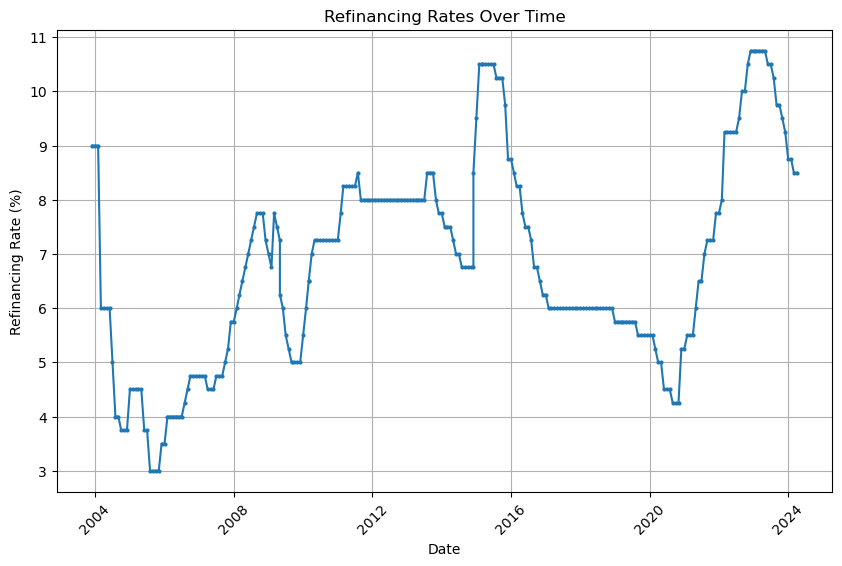

In [9]:
# Correctly convert PeriodIndex to DateTimeIndex
refinancing_rate.index = refinancing_rate.index.to_timestamp()

# Now proceed with plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(refinancing_rate.index, refinancing_rate['Refinancing_Rates'], marker='o', linestyle='-', markersize=2)
plt.title('Refinancing Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.show()

In [10]:
refinancing_rate = refinancing_rate.reset_index()

In [11]:
# Check for duplicated 'Start_Date'
duplicates = refinancing_rate[refinancing_rate['Start_Date'].duplicated(keep=False)]

#refinancing_rate = refinancing_rate.drop_duplicates(subset='Start_Date', keep='first')


# Print duplicate rows
print(duplicates)

    Start_Date  Refinancing_Rates
65  2009-05-01               7.25
66  2009-05-01               6.25
76  2010-03-01               6.50
77  2010-03-01               6.50
134 2014-12-01               6.75
135 2014-12-01               8.50
138 2015-03-01              10.50
139 2015-03-01              10.50


In [12]:
# Group by 'Start_Date' and calculate the mean of 'Refinancing_Rates' for each group
refinancing_rate = refinancing_rate.groupby('Start_Date', as_index=False)['Refinancing_Rates'].mean()

In [13]:
refinancing_rate.set_index('Start_Date', inplace=True)
max_date = refinancing_rate.index.max()
print(max_date)

2024-04-01 00:00:00


# Georgia policy rate

In [14]:
url = "https://analytics.nbg.gov.ge/views/MonetaryPolicyRate/PolicyRatesTable.csv"

In [15]:
georgia_policy = pd.read_csv(url)

print(georgia_policy.head())

       Date_    Rate
0  9/12/2008  10.00%
1  9/13/2008  10.00%
2  9/14/2008  10.00%
3  9/15/2008  10.00%
4  9/16/2008  10.00%


In [16]:
# Assuming your DataFrame is named georgia_policy

# Convert 'Date_' to datetime
georgia_policy['Date_'] = pd.to_datetime(georgia_policy['Date_'])

# Filter to keep only the first day of each month
georgia_policy = georgia_policy[georgia_policy['Date_'].dt.day == 1]

# Your georgia_policy_first_days now contains only the entries for the first day of each month
new_row = pd.DataFrame({'Date_': ['9/1/2008'], 'Rate': ['10.00%']})

# Convert 'Date_' to datetime to match your existing DataFrame
new_row['Date_'] = pd.to_datetime(new_row['Date_'])

# Concatenate the new_row DataFrame with your existing georgia_policy DataFrame
georgia_policy = pd.concat([new_row, georgia_policy], ignore_index=True)

georgia_policy['Rate'] = georgia_policy['Rate'].str.rstrip('%').astype('float') 

In [17]:
georgia_policy

,Date_,Rate
0,2008-09-01,10.00
1,2008-10-01,10.00
2,2008-11-01,10.00
3,2008-12-01,9.00
4,2009-01-01,8.00
...,...,...
184,2024-01-01,9.50
185,2024-02-01,9.00
186,2024-03-01,9.00
187,2024-04-01,8.25


In [18]:
georgia_policy.rename(columns={'Date_': 'Start_Date','Rate':'georgia_rate'}, inplace=True)

In [19]:
georgia_policy_head = refinancing_rate.reset_index()
georgia_policy_head = georgia_policy_head[georgia_policy_head['Start_Date'] <= pd.Timestamp('2008-08-01')]
georgia_policy_head

,Start_Date,Refinancing_Rates
0,2003-12-01,9.00
1,2004-01-01,9.00
2,2004-02-01,9.00
3,2004-03-01,6.00
4,2004-04-01,6.00
5,2004-05-01,6.00
6,2004-06-01,6.00
7,2004-07-01,5.00
8,2004-08-01,4.00
9,2004-09-01,4.00


In [20]:
# Step 1: Rename the columns in georgia_policy to match those in georgia_policy_head
georgia_policy.rename(columns={'georgia_rate': 'Refinancing_Rates'}, inplace=True)

# Ensure both DataFrames have the same format for 'Start_Date'
georgia_policy_head['Start_Date'] = pd.to_datetime(georgia_policy_head['Start_Date'])
georgia_policy['Start_Date'] = pd.to_datetime(georgia_policy['Start_Date'])

# Step 2: Concatenate the DataFrames
georgia_policy = pd.concat([georgia_policy_head, georgia_policy], ignore_index=True)

# To ensure no duplicate dates, especially if there's overlap in 'Start_Date':
georgia_policy.drop_duplicates(subset='Start_Date', keep='last', inplace=True)

# Sort by 'Start_Date' in case of any misalignment
georgia_policy.sort_values('Start_Date', inplace=True)

# Reset index after sorting
georgia_policy.reset_index(drop=True, inplace=True)

In [21]:
georgia_policy = georgia_policy[georgia_policy['Start_Date'] <= max_date]

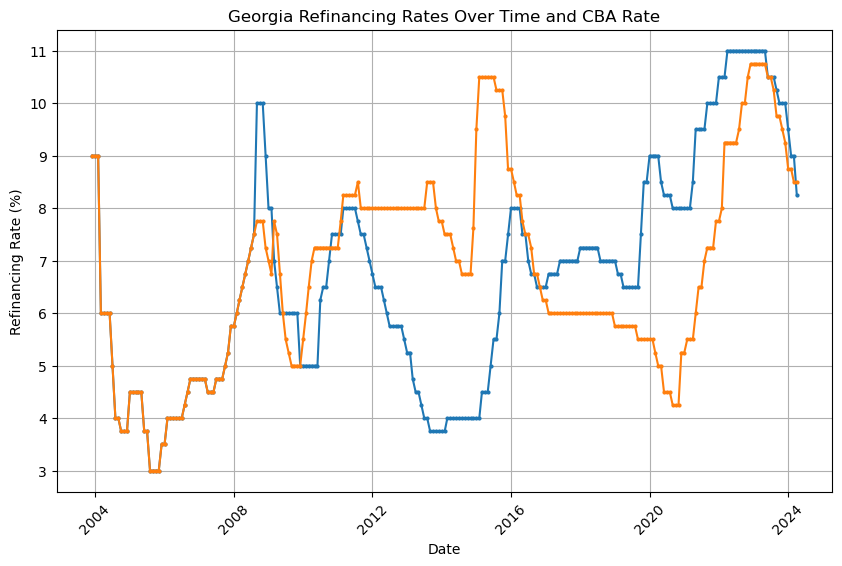

In [22]:
# Now proceed with plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(georgia_policy['Start_Date'], georgia_policy['Refinancing_Rates'], marker='o', linestyle='-', markersize=2)
plt.plot(refinancing_rate.index, refinancing_rate['Refinancing_Rates'], marker='o', linestyle='-', markersize=2)
plt.title('Georgia Refinancing Rates Over Time and CBA Rate')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.show()

In [23]:
# Convert 'Start_Date' to datetime
georgia_policy['Start_Date'] = pd.to_datetime(georgia_policy['Start_Date'])

# Set 'Start_Date' as index
georgia_policy.set_index('Start_Date', inplace=True)

# Create a full date range from start to end of your data, with monthly frequency
full_range = pd.date_range(start=georgia_policy.index.min(), end=georgia_policy.index.max(), freq='MS')

# Find missing months in your DataFrame
missing_months = full_range.difference(georgia_policy.index)

# Print missing months
print(missing_months)


DatetimeIndex([], dtype='datetime64[ns]', freq='MS')


In [24]:
georgia_policy.rename(columns={'Refinancing_Rates':'georgia_rate'}, inplace=True)

In [25]:
refinancing_rate

,Refinancing_Rates
Start_Date,
2003-12-01,9.00
2004-01-01,9.00
2004-02-01,9.00
2004-03-01,6.00
2004-04-01,6.00
...,...
2023-12-01,9.25
2024-01-01,8.75
2024-02-01,8.75


In [26]:
georgia_policy

,georgia_rate
Start_Date,
2003-12-01,9.00
2004-01-01,9.00
2004-02-01,9.00
2004-03-01,6.00
2004-04-01,6.00
...,...
2023-12-01,10.00
2024-01-01,9.50
2024-02-01,9.00


In [27]:


# Merge the DataFrames on their index
data = pd.merge(refinancing_rate, georgia_policy, left_index=True, right_index=True, how='outer')


In [28]:
data

,Refinancing_Rates,georgia_rate
Start_Date,,
2003-12-01,9.00,9.00
2004-01-01,9.00,9.00
2004-02-01,9.00,9.00
2004-03-01,6.00,6.00
2004-04-01,6.00,6.00
...,...,...
2023-12-01,9.25,10.00
2024-01-01,8.75,9.50
2024-02-01,8.75,9.00


# Russia Refinancing Rate

In [29]:
# Send the HTTP request and get the response
url = "https://www.cbr.ru/eng/statistics/idkp_br/refinancing_rates_e1/"
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table - adjust this based on actual HTML structure
table = soup.find('table')

# Initialize an empty list to store data
data_scrape = []

# Loop through each row in the table
for row in table.find_all('tr'):
    # Extract text from each cell in the row
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    # Append the list of text (a single row of data) to the data list
    if cols:  # This ensures we skip empty rows if present
        data_scrape.append(cols)

# Create a DataFrame with the collected data
russia_rate = pd.DataFrame(data_scrape, columns=['Date Range', 'Rate'])

# Display the DataFrame
print(russia_rate)


                                           Date Range  \
0                                From January 1, 2016   
1   September 14, 2012 — December \r\n\t\t\t\t\t\t...   
2              December 26, 2011 — September 13, 2012   
3                     May 3, 2011 — December 25, 2011   
4                     February 28, 2011 — May 2, 2011   
..                                                ...   
81                       June 2, 1993 — June 21, 1993   
82                      March 30, 1993 — June 1, 1993   
83                      May 23, 1992 — March 29, 1993   
84                      April 10, 1992 — May 22, 1992   
85                    January 1, 1992 — April 9, 1992   

                                                 Rate  
0   Equal to the Bank of Russia key rate \r\n\t\t\...  
1                                                8.25  
2                                                   8  
3                                                8.25  
4                                  

In [30]:
russia_rate[['Start Date', 'End Date']] = russia_rate['Date Range'].str.split('—', expand=True)
russia_rate.drop('Date Range', axis=1, inplace=True)

In [31]:
russia_rate

,Rate,Start Date,End Date
0,Equal to the Bank of Russia key rate \r\n\t\t\...,"From January 1, 2016",None
1,8.25,"September 14, 2012","December \r\n\t\t\t\t\t\t31, 2015"
2,8,"December 26, 2011","September 13, 2012"
3,8.25,"May 3, 2011","December 25, 2011"
4,8,"February 28, 2011","May 2, 2011"
...,...,...,...
81,110,"June 2, 1993","June 21, 1993"
82,100,"March 30, 1993","June 1, 1993"
83,80,"May 23, 1992","March 29, 1993"
84,50,"April 10, 1992","May 22, 1992"


In [32]:
# Create DataFrame named russia_rate


# Convert 'Start Date' and 'End Date' to datetime, ensuring that NaT is handled correctly
russia_rate['Start Date'] = pd.to_datetime(russia_rate['Start Date'], errors='coerce')
russia_rate['End Date'] = pd.to_datetime(russia_rate['End Date'], errors='coerce')

# Cleaning the 'Rate' column
russia_rate['Rate'] = russia_rate['Rate'].str.replace(r'\r\n\t\t\t\t\t\t', ' ', regex=True)
russia_rate['Rate'] = russia_rate['Rate'].str.strip()

# Handling 'Equal to the Bank of Russia key rate set as of the respective date'
russia_rate['Rate'] = russia_rate['Rate'].replace({'Equal to the Bank of Russia key rate set as of the respective date': 'Variable'})

# Display the cleaned DataFrame
print(russia_rate)

                                                 Rate Start Date   End Date
0   Equal to the Bank of Russia key rate  set as o...        NaT        NaT
1                                                8.25 2012-09-14 2015-12-31
2                                                   8 2011-12-26 2012-09-13
3                                                8.25 2011-05-03 2011-12-25
4                                                   8 2011-02-28 2011-05-02
..                                                ...        ...        ...
81                                                110 1993-06-02 1993-06-21
82                                                100 1993-03-30 1993-06-01
83                                                 80 1992-05-23 1993-03-29
84                                                 50 1992-04-10 1992-05-22
85                                                 20 1992-01-01 1992-04-09

[86 rows x 3 columns]


In [33]:
print(russia_rate.columns)

Index(['Rate', 'Start Date', 'End Date'], dtype='object')


In [34]:
# Assuming russia_rate is your DataFrame
russia_rate = russia_rate.drop(russia_rate.index[0])

In [35]:
russia_rate

,Rate,Start Date,End Date
1,8.25,2012-09-14,2015-12-31
2,8,2011-12-26,2012-09-13
3,8.25,2011-05-03,2011-12-25
4,8,2011-02-28,2011-05-02
5,7.75,2010-06-01,2011-02-27
...,...,...,...
81,110,1993-06-02,1993-06-21
82,100,1993-03-30,1993-06-01
83,80,1992-05-23,1993-03-29
84,50,1992-04-10,1992-05-22


In [36]:
# Reverse the DataFrame
russia_rate = russia_rate.iloc[::-1].reset_index(drop=True)

# Now russia_rate_reversed will have the earliest dates at the top
print(russia_rate)

    Rate Start Date   End Date
0     20 1992-01-01 1992-04-09
1     50 1992-04-10 1992-05-22
2     80 1992-05-23 1993-03-29
3    100 1993-03-30 1993-06-01
4    110 1993-06-02 1993-06-21
..   ...        ...        ...
80  7.75 2010-06-01 2011-02-27
81     8 2011-02-28 2011-05-02
82  8.25 2011-05-03 2011-12-25
83     8 2011-12-26 2012-09-13
84  8.25 2012-09-14 2015-12-31

[85 rows x 3 columns]


In [37]:
# Initialize a list to collect DataFrame parts
data_frames = []

# Loop through each row in your DataFrame
for index, row in russia_rate.iterrows():
    # Create a monthly period range from 'Start Date' to 'End Date'
    monthly_range = pd.date_range(start=row['Start Date'], end=row['End Date'], freq='MS')
    # Create a temporary DataFrame with dates and the corresponding rate
    temp_df = pd.DataFrame({
        'Date': monthly_range,
        'Rate': [row['Rate']] * len(monthly_range)
    })
    # Append the temporary DataFrame part to the list
    data_frames.append(temp_df)

# Concatenate all parts into one DataFrame outside of the loop
expanded_data = pd.concat(data_frames, ignore_index=True)

# Print the result
print(expanded_data)

          Date  Rate
0   1992-01-01    20
1   1992-02-01    20
2   1992-03-01    20
3   1992-04-01    20
4   1992-05-01    50
..         ...   ...
289 2015-08-01  8.25
290 2015-09-01  8.25
291 2015-10-01  8.25
292 2015-11-01  8.25
293 2015-12-01  8.25

[294 rows x 2 columns]


In [38]:
# Assuming expanded_data is already defined and contains the 'Date' and 'Rate' columns
# Ensure 'Date' is in datetime format
expanded_data['Date'] = pd.to_datetime(expanded_data['Date'])

# Select rows starting from '2003-12-01'
russia_rate_until_2016 = expanded_data[expanded_data['Date'] >= pd.Timestamp('2003-12-01')]

# Print the new DataFrame
print(russia_rate_until_2016)


          Date  Rate
149 2003-12-01    16
150 2004-01-01    16
151 2004-02-01    14
152 2004-03-01    14
153 2004-04-01    14
..         ...   ...
289 2015-08-01  8.25
290 2015-09-01  8.25
291 2015-10-01  8.25
292 2015-11-01  8.25
293 2015-12-01  8.25

[145 rows x 2 columns]


In [39]:
# Send the HTTP request and get the response
url = "https://cbr.ru/eng/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2016&UniDbQuery.To=12.04.2024"
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table - adjust this based on actual HTML structure
table = soup.find('table')

# Initialize an empty list to store data_scrape
data_scrape = []

# Loop through each row in the table
for row in table.find_all('tr'):
    # Extract text from each cell in the row
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    # Append the list of text (a single row of data_scrape) to the data_scrape list
    if cols:  # This ensures we skip empty rows if present
        data_scrape.append(cols)

# Create a data_scrapeFrame with the collected data_scrape
russia_rate_after_2016 = pd.DataFrame(data_scrape, columns=['Date Range', 'Rate'])

# Display the data_scrapeFrame
print(russia_rate_after_2016)

      Date Range   Rate
0     12.04.2024  16.00
1     11.04.2024  16.00
2     10.04.2024  16.00
3     09.04.2024  16.00
4     08.04.2024  16.00
...          ...    ...
2066  14.01.2016  11.00
2067  13.01.2016  11.00
2068  12.01.2016  11.00
2069  11.01.2016  11.00
2070  01.01.2016  11.00

[2071 rows x 2 columns]


In [40]:
russia_rate_after_2016['Date Range'] = pd.to_datetime(russia_rate_after_2016['Date Range'], format='%d.%m.%Y')

# Sort the DataFrame by date
russia_rate_after_2016 = russia_rate_after_2016.sort_values('Date Range')

# Set 'Date Range' as the DataFrame index
russia_rate_after_2016.set_index('Date Range', inplace=True)

# Resample to get the last rate of each month
russia_rate_after_2016 = russia_rate_after_2016.resample('M').last()
# Adjust the index to the first of each month
russia_rate_after_2016.index = russia_rate_after_2016.index - pd.offsets.MonthBegin(1)

# Reset index to turn 'Date Range' back into a column
russia_rate_after_2016.reset_index(inplace=True)

# Display the resulting DataFrame
print(russia_rate_after_2016)

   Date Range   Rate
0  2016-01-01  11.00
1  2016-02-01  11.00
2  2016-03-01  11.00
3  2016-04-01  11.00
4  2016-05-01  11.00
..        ...    ...
95 2023-12-01  16.00
96 2024-01-01  16.00
97 2024-02-01  16.00
98 2024-03-01  16.00
99 2024-04-01  16.00

[100 rows x 2 columns]


In [41]:
russia_rate_after_2016.rename(columns={'Date Range': 'Date'}, inplace=True)


russia_rate = pd.concat([russia_rate_until_2016, russia_rate_after_2016], ignore_index=True)

# Display the combined DataFrame
print(russia_rate)

          Date   Rate
0   2003-12-01     16
1   2004-01-01     16
2   2004-02-01     14
3   2004-03-01     14
4   2004-04-01     14
..         ...    ...
240 2023-12-01  16.00
241 2024-01-01  16.00
242 2024-02-01  16.00
243 2024-03-01  16.00
244 2024-04-01  16.00

[245 rows x 2 columns]


In [42]:
#russia_rate = russia_rate[russia_rate['Date'] <= pd.Timestamp('2024-02-01')]
russia_rate = russia_rate.rename(columns={'Rate': 'Russia Rate'})

russia_rate

,Date,Russia Rate
0,2003-12-01,16
1,2004-01-01,16
2,2004-02-01,14
3,2004-03-01,14
4,2004-04-01,14
...,...,...
240,2023-12-01,16.00
241,2024-01-01,16.00
242,2024-02-01,16.00
243,2024-03-01,16.00


In [43]:
data = data.reset_index()

In [44]:
# Merging the DataFrames on their respective date columns
data = pd.merge(data, russia_rate, left_on='Start_Date', right_on='Date', how='outer')

# If you want to drop one of the date columns after merging, since they are redundant, you can do so. For example, to drop 'Time_Period':
data.drop(columns='Date', inplace=True)

data

,Start_Date,Refinancing_Rates,georgia_rate,Russia Rate
0,2003-12-01,9.00,9.00,16
1,2004-01-01,9.00,9.00,16
2,2004-02-01,9.00,9.00,14
3,2004-03-01,6.00,6.00,14
4,2004-04-01,6.00,6.00,14
...,...,...,...,...
240,2023-12-01,9.25,10.00,16.00
241,2024-01-01,8.75,9.50,16.00
242,2024-02-01,8.75,9.00,16.00
243,2024-03-01,8.50,9.00,16.00


# dolarization

In [45]:
url = 'https://www.cba.am/stat/stat_data_eng/5_Deposits%20by%20sectors_eng.xlsx'

In [46]:
deposits = pd.read_excel(url)

print(deposits)

    COMMERCIAL BANKS DEPOSITS BY SECTORS OF ECONOMY 1           Unnamed: 1  \
0                            (end of period, mln AMD)                  NaN   
1                                                 NaN                  NaN   
2                                             Column1            Column110   
3                                                 NaN  2000-01-01 00:00:00   
4                                      Non Residents2         33613.476513   
5                                                  FX         31572.713943   
6                                                 AMD           2040.76257   
7                                           Residents         66613.842576   
8                                                 AMD         15730.223768   
9                Demand Deposits (including accounts)         11342.443363   
10                         Non-Financial Corporations          9484.700614   
11                                            Private          6

In [47]:
# Step 1: Extract years and values
years = deposits.iloc[3, 1:]  # Skip the first column which is a description, not a year
residents = deposits.iloc[7, 1:]  # Similarly, skip the description column
fx = deposits.iloc[25, 1:]

# Step 2: Create a new DataFrame with 'Year' and 'Total loans of banking system / GDP' as columns
deposits_new = pd.DataFrame({
    'Time_Period': years.values,  # Convert to array to ensure proper formatting
    'Residents': residents.values,  # Ditto
    'FX': fx.values
})

In [48]:
deposits_new

,Time_Period,Residents,FX
0,2000-01-01,66613.842576,50883.618809
1,2000-02-01,68854.367334,54183.320013
2,2000-03-01,73008.897743,56984.564361
3,2000-04-01,72366.141054,56525.324563
4,2000-05-01,73327.849158,57611.385772
...,...,...,...
285,2023-10-31,4202574.867869,1763710.10907
286,2023-11-30,4230840.320815,1756651.023428
287,2023-12-31,4320279.315355,1755887.26559
288,2024-01-31,4267342.85177,1744397.570658


In [49]:
deposits_new['Dolarization'] = deposits_new['Residents']/deposits_new['FX']
deposits_new = deposits_new.drop('FX', axis = 1)
deposits_new = deposits_new.drop('Residents', axis = 1)
deposits_new['Time_Period'] = pd.to_datetime(deposits_new['Time_Period'])
deposits_new['Dolarization'] = pd.to_numeric(deposits_new['Dolarization'])

In [50]:
deposits_new = deposits_new[deposits_new['Time_Period'] >= '2003-12-01']
deposits_new['Time_Period'] = deposits_new['Time_Period'].dt.to_period('M').dt.to_timestamp()

In [51]:
deposits_new

,Time_Period,Dolarization
47,2003-12-01,1.406075
48,2004-01-01,1.402145
49,2004-02-01,1.378638
50,2004-03-01,1.373693
51,2004-04-01,1.389632
...,...,...
285,2023-10-01,2.382804
286,2023-11-01,2.408469
287,2023-12-01,2.460454
288,2024-01-01,2.446313


In [52]:
data

,Start_Date,Refinancing_Rates,georgia_rate,Russia Rate
0,2003-12-01,9.00,9.00,16
1,2004-01-01,9.00,9.00,16
2,2004-02-01,9.00,9.00,14
3,2004-03-01,6.00,6.00,14
4,2004-04-01,6.00,6.00,14
...,...,...,...,...
240,2023-12-01,9.25,10.00,16.00
241,2024-01-01,8.75,9.50,16.00
242,2024-02-01,8.75,9.00,16.00
243,2024-03-01,8.50,9.00,16.00


In [53]:
# Merge DataFrames on date columns
merged_df = pd.merge(data, deposits_new, left_on='Start_Date', right_on='Time_Period', how='left')

# Drop the additional date column if needed
merged_df.drop(columns=['Time_Period'], inplace=True)

# Fill NA values with the value from the previous month
merged_df['Dolarization'].fillna(method='ffill', inplace=True)

In [54]:
merged_df = merged_df.rename(columns={'Start_Date': 'Time_Period'})

In [55]:
merged_df

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,Dolarization
0,2003-12-01,9.00,9.00,16,1.406075
1,2004-01-01,9.00,9.00,16,1.402145
2,2004-02-01,9.00,9.00,14,1.378638
3,2004-03-01,6.00,6.00,14,1.373693
4,2004-04-01,6.00,6.00,14,1.389632
...,...,...,...,...,...
240,2023-12-01,9.25,10.00,16.00,2.460454
241,2024-01-01,8.75,9.50,16.00,2.446313
242,2024-02-01,8.75,9.00,16.00,2.449819
243,2024-03-01,8.50,9.00,16.00,2.449819


In [56]:
data = merged_df

In [57]:
print(data.columns)

Index(['Time_Period', 'Refinancing_Rates', 'georgia_rate', 'Russia Rate',
       'Dolarization'],
      dtype='object')


In [58]:
data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,Dolarization
0,2003-12-01,9.00,9.00,16,1.406075
1,2004-01-01,9.00,9.00,16,1.402145
2,2004-02-01,9.00,9.00,14,1.378638
3,2004-03-01,6.00,6.00,14,1.373693
4,2004-04-01,6.00,6.00,14,1.389632
...,...,...,...,...,...
240,2023-12-01,9.25,10.00,16.00,2.460454
241,2024-01-01,8.75,9.50,16.00,2.446313
242,2024-02-01,8.75,9.00,16.00,2.449819
243,2024-03-01,8.50,9.00,16.00,2.449819


# test

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [60]:
data['Time_Period'] = pd.to_datetime(data['Time_Period'])
data['Year'] = data['Time_Period'].dt.year
data['Month'] = data['Time_Period'].dt.month

In [61]:
# Prepare features and target variable
X = data[['Year', 'Month','Dolarization']]  # Add more features if needed
y = data['Refinancing_Rates']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 4.53
R-squared: 0.08


worse than expected continue to make the data bigger with features included 

In [62]:
data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,Dolarization,Year,Month
0,2003-12-01,9.00,9.00,16,1.406075,2003,12
1,2004-01-01,9.00,9.00,16,1.402145,2004,1
2,2004-02-01,9.00,9.00,14,1.378638,2004,2
3,2004-03-01,6.00,6.00,14,1.373693,2004,3
4,2004-04-01,6.00,6.00,14,1.389632,2004,4
...,...,...,...,...,...,...,...
240,2023-12-01,9.25,10.00,16.00,2.460454,2023,12
241,2024-01-01,8.75,9.50,16.00,2.446313,2024,1
242,2024-02-01,8.75,9.00,16.00,2.449819,2024,2
243,2024-03-01,8.50,9.00,16.00,2.449819,2024,3


# core_infaltion

In [63]:
core_inflation = pd.read_excel("https://www.cba.am/stat/stat_data_eng/core_inflation_CBA_eng.xlsx")

# Display the data
print(core_inflation)

    Unnamed: 0                                     CORE INFLATION  \
0          NaN  Seasonal Products &\nAdministrative Regulated ...   
1          NaN    compared to the same month of the previous year   
2       2006/1                                           98.59481   
3       2006/2                                          99.083378   
4       2006/3                                           99.60412   
..         ...                                                ...   
220     2024/3                                          99.290137   
221        NaN                                                NaN   
222          *  currently this indicator is being used for CBA...   
223         **  this indicator is being used for other analyti...   
224        ***  due to consumer basket weights review by SC RA...   

                         Unnamed: 2  \
0                               NaN   
1    compared to the previous month   
2                        100.291715   
3              

In [64]:
core_inflation = core_inflation.iloc[:, [0, 1, 3]]

print(core_inflation)

    Unnamed: 0                                     CORE INFLATION  \
0          NaN  Seasonal Products &\nAdministrative Regulated ...   
1          NaN    compared to the same month of the previous year   
2       2006/1                                           98.59481   
3       2006/2                                          99.083378   
4       2006/3                                           99.60412   
..         ...                                                ...   
220     2024/3                                          99.290137   
221        NaN                                                NaN   
222          *  currently this indicator is being used for CBA...   
223         **  this indicator is being used for other analyti...   
224        ***  due to consumer basket weights review by SC RA...   

                                          Unnamed: 3  
0                    Exclusion & Adjustment method**  
1    compared to the same month of the previous year  
2     

In [65]:
core_inflation.dropna(inplace=True)

print(core_inflation)

    Unnamed: 0 CORE INFLATION  Unnamed: 3
2       2006/1       98.59481   98.743545
3       2006/2      99.083378   99.101892
4       2006/3       99.60412   99.447619
5       2006/4     101.191824  100.872023
6       2006/5     102.216325  101.712238
..         ...            ...         ...
216    2023/11      99.756096  100.990389
217    2023/12      99.606461  100.704472
218  2024/1***      99.559165  100.500455
219     2024/2      99.345842  100.132493
220     2024/3      99.290137   100.13223

[219 rows x 3 columns]


In [66]:
core_inflation.rename(columns={'Unnamed: 0': 'Time_Period', 'CORE INFLATION': 'Core_Inflation_1', 'Unnamed: 3': 'Core_Inflation_2'}, inplace=True)

print(core_inflation)

    Time_Period Core_Inflation_1 Core_Inflation_2
2        2006/1         98.59481        98.743545
3        2006/2        99.083378        99.101892
4        2006/3         99.60412        99.447619
5        2006/4       101.191824       100.872023
6        2006/5       102.216325       101.712238
..          ...              ...              ...
216     2023/11        99.756096       100.990389
217     2023/12        99.606461       100.704472
218   2024/1***        99.559165       100.500455
219      2024/2        99.345842       100.132493
220      2024/3        99.290137        100.13223

[219 rows x 3 columns]


In [67]:
core_inflation['Core_Inflation_1'] = core_inflation['Core_Inflation_1']-100
core_inflation['Core_Inflation_2'] = core_inflation['Core_Inflation_2']-100

print(core_inflation)

    Time_Period Core_Inflation_1 Core_Inflation_2
2        2006/1         -1.40519        -1.256455
3        2006/2        -0.916622        -0.898108
4        2006/3         -0.39588        -0.552381
5        2006/4         1.191824         0.872023
6        2006/5         2.216325         1.712238
..          ...              ...              ...
216     2023/11        -0.243904         0.990389
217     2023/12        -0.393539         0.704472
218   2024/1***        -0.440835         0.500455
219      2024/2        -0.654158         0.132493
220      2024/3        -0.709863          0.13223

[219 rows x 3 columns]


In [68]:
# Convert 'Time_Period' to datetime format if it's not already
core_inflation['Time_Period'] = core_inflation['Time_Period'].str.replace('\*\*\*', '', regex=True)

core_inflation['Time_Period'] = pd.to_datetime(core_inflation['Time_Period'])



In [69]:
core_inflation

,Time_Period,Core_Inflation_1,Core_Inflation_2
2,2006-01-01,-1.40519,-1.256455
3,2006-02-01,-0.916622,-0.898108
4,2006-03-01,-0.39588,-0.552381
5,2006-04-01,1.191824,0.872023
6,2006-05-01,2.216325,1.712238
...,...,...,...
216,2023-11-01,-0.243904,0.990389
217,2023-12-01,-0.393539,0.704472
218,2024-01-01,-0.440835,0.500455
219,2024-02-01,-0.654158,0.132493


In [70]:
# Filter the DataFrame to include only rows on or after 2006-01-01
filtered_data = data[data['Time_Period'] >= pd.Timestamp('2006-01-01')]

In [71]:
# Merge DataFrames on date columns
filtered_data = pd.merge(filtered_data, core_inflation, left_on='Time_Period', right_on='Time_Period', how='left')

# Drop the additional date column if needed
#filtered_data.drop(columns=['Time_Period'], inplace=True)

# Fill NA values with the value from the previous month
filtered_data['Core_Inflation_1'].fillna(method='ffill', inplace=True)
filtered_data['Core_Inflation_2'].fillna(method='ffill', inplace=True)

In [72]:
# Merge core_inflation into filtered_data based on a common key (assuming 'Time_Period' is that key and exists in both)
#filtered_data = filtered_data.merge(core_inflation[['Time_Period', 'Core_Inflation_1', 'Core_Inflation_2']], on='Time_Period', how='left')


In [73]:
filtered_data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,Dolarization,Year,Month,Core_Inflation_1,Core_Inflation_2
0,2006-01-01,3.50,3.50,12,1.511290,2006,1,-1.405190,-1.256455
1,2006-02-01,4.00,4.00,12,1.536412,2006,2,-0.916622,-0.898108
2,2006-03-01,4.00,4.00,12,1.542730,2006,3,-0.395880,-0.552381
3,2006-04-01,4.00,4.00,12,1.548592,2006,4,1.191824,0.872023
4,2006-05-01,4.00,4.00,12,1.561499,2006,5,2.216325,1.712238
...,...,...,...,...,...,...,...,...,...
215,2023-12-01,9.25,10.00,16.00,2.460454,2023,12,-0.393539,0.704472
216,2024-01-01,8.75,9.50,16.00,2.446313,2024,1,-0.440835,0.500455
217,2024-02-01,8.75,9.00,16.00,2.449819,2024,2,-0.654158,0.132493
218,2024-03-01,8.50,9.00,16.00,2.449819,2024,3,-0.709863,0.132230


# test 1

In [74]:
# Prepare features and target variable
X = filtered_data[['Year', 'Month','Core_Inflation_1', 'Core_Inflation_2']]  # Add more features if needed
y = filtered_data['Refinancing_Rates']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 3.59
R-squared: 0.13


better with core inflation

# consumer_price_index

In [75]:
consumer_price_index = pd.read_excel("https://www.cba.am/stat/stat_data_eng/6_CPI_eng.xls")

# Display the data
print(consumer_price_index)

                     Consumer price index (monthly), %  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                               1996/1   
4                                               1996/2   
..                                                 ...   
340                                             2024/2   
341                                             2024/3   
342                                                NaN   
343  Source: Statistical Committee of the Republic ...   
344  *based on the revised weights of the consumpti...   

                         Unnamed: 1  \
0                               NaN   
1    Compared to the previous month   
2                               CPI   
3                            103.61   
4                        103.378052   
..                              ...   
340                       99.2

In [76]:
consumer_price_index = consumer_price_index.iloc[:, [0, 8]]

print(consumer_price_index)

                     Consumer price index (monthly), %  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                               1996/1   
4                                               1996/2   
..                                                 ...   
340                                             2024/2   
341                                             2024/3   
342                                                NaN   
343  Source: Statistical Committee of the Republic ...   
344  *based on the revised weights of the consumpti...   

                                            Unnamed: 8  
0                                                  NaN  
1                                                  NaN  
2    CPI, compared to the same period of the previo...  
3                                           131.788907  
4                 

In [77]:
consumer_price_index.dropna(inplace=True)

print(consumer_price_index)

    Consumer price index (monthly), %  Unnamed: 8
3                              1996/1  131.788907
4                              1996/2  133.518896
5                              1996/3  133.619388
6                              1996/4  131.187826
7                              1996/5  127.697011
..                                ...         ...
337                           2023/11  102.224546
338                           2023/12  101.980419
339                           2024/1*   99.140456
340                            2024/2   98.744512
341                            2024/3   98.762526

[339 rows x 2 columns]


In [78]:
consumer_price_index.rename(columns={'Consumer price index (monthly), %': 'Time_Period', 'Unnamed: 8': 'CPI'}, inplace=True)

print(consumer_price_index)

    Time_Period         CPI
3        1996/1  131.788907
4        1996/2  133.518896
5        1996/3  133.619388
6        1996/4  131.187826
7        1996/5  127.697011
..          ...         ...
337     2023/11  102.224546
338     2023/12  101.980419
339     2024/1*   99.140456
340      2024/2   98.744512
341      2024/3   98.762526

[339 rows x 2 columns]


In [79]:
consumer_price_index['CPI'] = consumer_price_index['CPI']-100

print(consumer_price_index)

    Time_Period        CPI
3        1996/1  31.788907
4        1996/2  33.518896
5        1996/3  33.619388
6        1996/4  31.187826
7        1996/5  27.697011
..          ...        ...
337     2023/11   2.224546
338     2023/12   1.980419
339     2024/1*  -0.859544
340      2024/2  -1.255488
341      2024/3  -1.237474

[339 rows x 2 columns]


In [80]:
# Convert 'Time_Period' to datetime format if it's not already
consumer_price_index['Time_Period'] = consumer_price_index['Time_Period'].str.replace('\*', '', regex=True)

consumer_price_index['Time_Period'] = pd.to_datetime(consumer_price_index['Time_Period'])

print(consumer_price_index)

    Time_Period        CPI
3    1996-01-01  31.788907
4    1996-02-01  33.518896
5    1996-03-01  33.619388
6    1996-04-01  31.187826
7    1996-05-01  27.697011
..          ...        ...
337  2023-11-01   2.224546
338  2023-12-01   1.980419
339  2024-01-01  -0.859544
340  2024-02-01  -1.255488
341  2024-03-01  -1.237474

[339 rows x 2 columns]


In [81]:
# Filter the DataFrame to include only rows on or after 2006-01-01
filtered_consumer_price_index = consumer_price_index[consumer_price_index['Time_Period'] >= pd.Timestamp('2003-12-01')]

print(filtered_consumer_price_index)

    Time_Period       CPI
98   2003-12-01  4.721553
99   2004-01-01  6.914182
100  2004-02-01   7.43394
101  2004-03-01  7.870907
102  2004-04-01  7.878875
..          ...       ...
337  2023-11-01  2.224546
338  2023-12-01  1.980419
339  2024-01-01 -0.859544
340  2024-02-01 -1.255488
341  2024-03-01 -1.237474

[244 rows x 2 columns]


In [82]:
filtered_consumer_price_index['CPI'] = pd.to_numeric(filtered_consumer_price_index['CPI'], errors='coerce')


C:\Users\zhora.stepanyan\AppData\Local\Temp\ipykernel_5432\964548041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_consumer_price_index['CPI'] = pd.to_numeric(filtered_consumer_price_index['CPI'], errors='coerce')


In [83]:
filtered_consumer_price_index

,Time_Period,CPI
98,2003-12-01,4.721553
99,2004-01-01,6.914182
100,2004-02-01,7.433940
101,2004-03-01,7.870907
102,2004-04-01,7.878875
...,...,...
337,2023-11-01,2.224546
338,2023-12-01,1.980419
339,2024-01-01,-0.859544
340,2024-02-01,-1.255488


In [84]:
# Merge core_inflation into filtered_data based on a common key (assuming 'Time_Period' is that key and exists in both)
filtered_data = filtered_data.merge(consumer_price_index[['Time_Period', 'CPI']], on='Time_Period', how='left')
filtered_data['CPI'].fillna(method='ffill', inplace=True)

In [85]:
filtered_data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,Dolarization,Year,Month,Core_Inflation_1,Core_Inflation_2,CPI
0,2006-01-01,3.50,3.50,12,1.511290,2006,1,-1.405190,-1.256455,-2.973920
1,2006-02-01,4.00,4.00,12,1.536412,2006,2,-0.916622,-0.898108,-2.529050
2,2006-03-01,4.00,4.00,12,1.542730,2006,3,-0.395880,-0.552381,-2.043668
3,2006-04-01,4.00,4.00,12,1.548592,2006,4,1.191824,0.872023,-1.509252
4,2006-05-01,4.00,4.00,12,1.561499,2006,5,2.216325,1.712238,-0.729713
...,...,...,...,...,...,...,...,...,...,...
215,2023-12-01,9.25,10.00,16.00,2.460454,2023,12,-0.393539,0.704472,1.980419
216,2024-01-01,8.75,9.50,16.00,2.446313,2024,1,-0.440835,0.500455,-0.859544
217,2024-02-01,8.75,9.00,16.00,2.449819,2024,2,-0.654158,0.132493,-1.255488
218,2024-03-01,8.50,9.00,16.00,2.449819,2024,3,-0.709863,0.132230,-1.237474


In [86]:
# Prepare features and target variable
X = filtered_data[['Year', 'Month','CPI']]  # Add more features if needed
y = filtered_data['Refinancing_Rates']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 3.21
R-squared: 0.22


In [87]:
bank_gdp = pd.read_excel("https://www.cba.am/Storage/EN/stat_data_eng/Banks-GDP-Eng.xls")

# Display the data
print(bank_gdp)

   Unnamed: 0                            Unnamed: 1   Unnamed: 2   Unnamed: 3  \
0         NaN                                     %  2000.000000  2001.000000   
1         NaN  Total assets of banking system / GDP    22.789411    19.778436   
2         NaN    Total loans of banking system /GDP     9.622451     7.112804   

    Unnamed: 4   Unnamed: 5   Unnamed: 6   Unnamed: 7   Unnamed: 8  \
0  2002.000000  2003.000000  2004.000000  2005.000000  2006.000000   
1    18.394429    17.635792    19.055448    19.647684    19.746988   
2     6.666744     6.618765     7.521472     8.702935     9.170270   

    Unnamed: 9  ...  Unnamed: 15  Unnamed: 16  Unnamed: 17  Unnamed: 18  \
0  2007.000000  ...  2013.000000  2014.000000  2015.000000  2016.000000   
1    24.274071  ...    68.985040    70.277401    68.491130    78.673023   
2    13.531658  ...    42.145291    42.725805    39.837822    45.768753   

   Unnamed: 19  Unnamed: 20  Unnamed: 21  Unnamed: 22  Unnamed: 23  \
0  2017.000000   2018.0

In [88]:
# Step 1: Extract years and values
years = bank_gdp.iloc[0, 1:]  # Skip the first column which is a description, not a year
values = bank_gdp.iloc[2, 1:]  # Similarly, skip the description column

# Step 2: Create a new DataFrame with 'Year' and 'Total loans of banking system / GDP' as columns
bank_gdp = pd.DataFrame({
    'Time_Period': years.values,  # Convert to array to ensure proper formatting
    'Total loans of banking system / GDP': values.values  # Ditto
})

In [89]:
bank_gdp

,Time_Period,Total loans of banking system / GDP
0,%,Total loans of banking system /GDP
1,2000.0,9.622451
2,2001.0,7.112804
3,2002.0,6.666744
4,2003.0,6.618765
5,2004.0,7.521472
6,2005.0,8.702935
7,2006.0,9.17027
8,2007.0,13.531658
9,2008.0,17.781802


In [90]:
bank_gdp = bank_gdp.drop(0)

In [91]:
bank_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 1 to 23
Data columns (total 2 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Time_Period                          23 non-null     object
 1   Total loans of banking system / GDP  23 non-null     object
dtypes: object(2)
memory usage: 500.0+ bytes


In [92]:
bank_gdp['Time_Period'] = pd.to_datetime(bank_gdp['Time_Period'].astype(int).astype(str) + '-01-01')

In [93]:
bank_gdp

,Time_Period,Total loans of banking system / GDP
1,2000-01-01,9.622451
2,2001-01-01,7.112804
3,2002-01-01,6.666744
4,2003-01-01,6.618765
5,2004-01-01,7.521472
6,2005-01-01,8.702935
7,2006-01-01,9.17027
8,2007-01-01,13.531658
9,2008-01-01,17.781802
10,2009-01-01,23.401706


In [94]:
expanded_bank_gdp = pd.DataFrame()

# Iterate over each row in bank_gdp to create 12 entries for each month of the year, duplicating the GDP values
for index, row in bank_gdp.iterrows():
    # Create a DataFrame for this row for each month
    year_df = pd.DataFrame({
        'Time_Period': pd.date_range(start=f"{row['Time_Period'].year}-01-01", periods=12, freq='MS'),
        'Total loans of banking system / GDP': row['Total loans of banking system / GDP']
    })
    # Append to the expanded DataFrame
    expanded_bank_gdp = pd.concat([expanded_bank_gdp, year_df], ignore_index=True)
    
expanded_bank_gdp

,Time_Period,Total loans of banking system / GDP
0,2000-01-01,9.622451
1,2000-02-01,9.622451
2,2000-03-01,9.622451
3,2000-04-01,9.622451
4,2000-05-01,9.622451
...,...,...
271,2022-08-01,45.930812
272,2022-09-01,45.930812
273,2022-10-01,45.930812
274,2022-11-01,45.930812


In [95]:
# Filter the DataFrame to include only rows on or after 2006-01-01
bank_gdp = expanded_bank_gdp[expanded_bank_gdp['Time_Period'] >= pd.Timestamp('2003-12-01')]

In [96]:
bank_gdp

,Time_Period,Total loans of banking system / GDP
47,2003-12-01,6.618765
48,2004-01-01,7.521472
49,2004-02-01,7.521472
50,2004-03-01,7.521472
51,2004-04-01,7.521472
...,...,...
271,2022-08-01,45.930812
272,2022-09-01,45.930812
273,2022-10-01,45.930812
274,2022-11-01,45.930812


In [97]:
# Merge core_inflation into filtered_data based on a common key (assuming 'Time_Period' is that key and exists in both)
filtered_data = filtered_data.merge(bank_gdp[['Time_Period', 'Total loans of banking system / GDP']], on='Time_Period', how='left')

In [98]:
filtered_data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,Dolarization,Year,Month,Core_Inflation_1,Core_Inflation_2,CPI,Total loans of banking system / GDP
0,2006-01-01,3.50,3.50,12,1.511290,2006,1,-1.405190,-1.256455,-2.973920,9.17027
1,2006-02-01,4.00,4.00,12,1.536412,2006,2,-0.916622,-0.898108,-2.529050,9.17027
2,2006-03-01,4.00,4.00,12,1.542730,2006,3,-0.395880,-0.552381,-2.043668,9.17027
3,2006-04-01,4.00,4.00,12,1.548592,2006,4,1.191824,0.872023,-1.509252,9.17027
4,2006-05-01,4.00,4.00,12,1.561499,2006,5,2.216325,1.712238,-0.729713,9.17027
...,...,...,...,...,...,...,...,...,...,...,...
215,2023-12-01,9.25,10.00,16.00,2.460454,2023,12,-0.393539,0.704472,1.980419,NaN
216,2024-01-01,8.75,9.50,16.00,2.446313,2024,1,-0.440835,0.500455,-0.859544,NaN
217,2024-02-01,8.75,9.00,16.00,2.449819,2024,2,-0.654158,0.132493,-1.255488,NaN
218,2024-03-01,8.50,9.00,16.00,2.449819,2024,3,-0.709863,0.132230,-1.237474,NaN


In [99]:
# Ensure 'Time_Period' is in datetime format
filtered_data['Time_Period'] = pd.to_datetime(filtered_data['Time_Period'])
filtered_data['Year'] = filtered_data['Time_Period'].dt.year

# Initialize a variable to hold the last known value (start with NaN and update as you find non-NaN values)
last_known_value = np.nan

# Iterate through each year in the DataFrame
for year in range(filtered_data['Year'].min(), filtered_data['Year'].max() + 1):
    # Check if there are NaN values for "Total loans of banking system / GDP" in the current year
    if filtered_data.loc[filtered_data['Year'] == year, 'Total loans of banking system / GDP'].isna().any():
        # If there's a last known value from a previous year, use it to fill NaNs for the current year
        if not np.isnan(last_known_value):
            filtered_data.loc[filtered_data['Year'] == year, 'Total loans of banking system / GDP'] = filtered_data.loc[filtered_data['Year'] == year, 'Total loans of banking system / GDP'].fillna(last_known_value)
    else:
        # Update the last known value with the last non-NaN value of the current year
        last_known_value = filtered_data.loc[filtered_data['Year'] == year, 'Total loans of banking system / GDP'].dropna().values[-1]

In [100]:
filtered_data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,Dolarization,Year,Month,Core_Inflation_1,Core_Inflation_2,CPI,Total loans of banking system / GDP
0,2006-01-01,3.50,3.50,12,1.511290,2006,1,-1.405190,-1.256455,-2.973920,9.170270
1,2006-02-01,4.00,4.00,12,1.536412,2006,2,-0.916622,-0.898108,-2.529050,9.170270
2,2006-03-01,4.00,4.00,12,1.542730,2006,3,-0.395880,-0.552381,-2.043668,9.170270
3,2006-04-01,4.00,4.00,12,1.548592,2006,4,1.191824,0.872023,-1.509252,9.170270
4,2006-05-01,4.00,4.00,12,1.561499,2006,5,2.216325,1.712238,-0.729713,9.170270
...,...,...,...,...,...,...,...,...,...,...,...
215,2023-12-01,9.25,10.00,16.00,2.460454,2023,12,-0.393539,0.704472,1.980419,45.930812
216,2024-01-01,8.75,9.50,16.00,2.446313,2024,1,-0.440835,0.500455,-0.859544,45.930812
217,2024-02-01,8.75,9.00,16.00,2.449819,2024,2,-0.654158,0.132493,-1.255488,45.930812
218,2024-03-01,8.50,9.00,16.00,2.449819,2024,3,-0.709863,0.132230,-1.237474,45.930812


In [101]:
# Prepare features and target variable
X = filtered_data[['Total loans of banking system / GDP']]  # Add more features if needed
y = filtered_data['Refinancing_Rates']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 6.10
R-squared: -0.48


In [102]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 0 to 219
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Time_Period                          220 non-null    datetime64[ns]
 1   Refinancing_Rates                    220 non-null    float64       
 2   georgia_rate                         220 non-null    float64       
 3   Russia Rate                          220 non-null    object        
 4   Dolarization                         220 non-null    float64       
 5   Year                                 220 non-null    int64         
 6   Month                                220 non-null    int64         
 7   Core_Inflation_1                     220 non-null    float64       
 8   Core_Inflation_2                     220 non-null    float64       
 9   CPI                                  220 non-null    float64       
 10  Total loans of

In [129]:
filtered_data['Dolarization'] = filtered_data['Dolarization'].astype(float)
filtered_data['Russia Rate'] = filtered_data['Russia Rate'].astype(float)
#filtered_data['Core_Inflation_1'] = filtered_data['Core_Inflation_1'].astype(float)
#filtered_data['Core_Inflation_2'] = filtered_data['Core_Inflation_2'].astype(float)
filtered_data['CPI'] = filtered_data['CPI'].astype(float)

In [104]:
# Prepare features and target variable
X = filtered_data[['Year','Month','CPI']]  # Add more features if needed
y = filtered_data['Refinancing_Rates']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 3.21
R-squared: 0.22


In [105]:
data = filtered_data

In [106]:
data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,Dolarization,Year,Month,Core_Inflation_1,Core_Inflation_2,CPI,Total loans of banking system / GDP
0,2006-01-01,3.50,3.50,12,1.511290,2006,1,-1.405190,-1.256455,-2.973920,9.170270
1,2006-02-01,4.00,4.00,12,1.536412,2006,2,-0.916622,-0.898108,-2.529050,9.170270
2,2006-03-01,4.00,4.00,12,1.542730,2006,3,-0.395880,-0.552381,-2.043668,9.170270
3,2006-04-01,4.00,4.00,12,1.548592,2006,4,1.191824,0.872023,-1.509252,9.170270
4,2006-05-01,4.00,4.00,12,1.561499,2006,5,2.216325,1.712238,-0.729713,9.170270
...,...,...,...,...,...,...,...,...,...,...,...
215,2023-12-01,9.25,10.00,16.00,2.460454,2023,12,-0.393539,0.704472,1.980419,45.930812
216,2024-01-01,8.75,9.50,16.00,2.446313,2024,1,-0.440835,0.500455,-0.859544,45.930812
217,2024-02-01,8.75,9.00,16.00,2.449819,2024,2,-0.654158,0.132493,-1.255488,45.930812
218,2024-03-01,8.50,9.00,16.00,2.449819,2024,3,-0.709863,0.132230,-1.237474,45.930812


In [107]:
international_reserves_total = pd.read_excel("https://www.cba.am/stat/stat_data_eng/7.International%20reserves_eng.xlsx")

# Display the data
print(international_reserves_total)

                             International Reserves 1           Unnamed: 1  \
0                                       (million USD)                  NaN   
1                                                 NaN                  NaN   
2                                                 NaN  2003-01-01 00:00:00   
3   Gross International Reserves (excluding privat...              421.399   
4                        Gross International Reserves           431.003714   
5                                                Gold            16.304434   
6                                        SDR holdings            26.372314   
7                         Reserve position in the IMF                    0   
8                                  Foreign Exchange 2           388.326965   
9                                                 NaN                  NaN   
10             1 Calculated at actual exchange rates.                  NaN   
11       2 Includes assets in convertible currencies.           

In [108]:
data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,Dolarization,Year,Month,Core_Inflation_1,Core_Inflation_2,CPI,Total loans of banking system / GDP
0,2006-01-01,3.50,3.50,12,1.511290,2006,1,-1.405190,-1.256455,-2.973920,9.170270
1,2006-02-01,4.00,4.00,12,1.536412,2006,2,-0.916622,-0.898108,-2.529050,9.170270
2,2006-03-01,4.00,4.00,12,1.542730,2006,3,-0.395880,-0.552381,-2.043668,9.170270
3,2006-04-01,4.00,4.00,12,1.548592,2006,4,1.191824,0.872023,-1.509252,9.170270
4,2006-05-01,4.00,4.00,12,1.561499,2006,5,2.216325,1.712238,-0.729713,9.170270
...,...,...,...,...,...,...,...,...,...,...,...
215,2023-12-01,9.25,10.00,16.00,2.460454,2023,12,-0.393539,0.704472,1.980419,45.930812
216,2024-01-01,8.75,9.50,16.00,2.446313,2024,1,-0.440835,0.500455,-0.859544,45.930812
217,2024-02-01,8.75,9.00,16.00,2.449819,2024,2,-0.654158,0.132493,-1.255488,45.930812
218,2024-03-01,8.50,9.00,16.00,2.449819,2024,3,-0.709863,0.132230,-1.237474,45.930812


In [109]:
data.isnull().sum().sum()

0

In [110]:
#data = data[['Refinancing_Rates','Year','Month','Dolarization','CPI']]

In [111]:
data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,Dolarization,Year,Month,Core_Inflation_1,Core_Inflation_2,CPI,Total loans of banking system / GDP
0,2006-01-01,3.50,3.50,12,1.511290,2006,1,-1.405190,-1.256455,-2.973920,9.170270
1,2006-02-01,4.00,4.00,12,1.536412,2006,2,-0.916622,-0.898108,-2.529050,9.170270
2,2006-03-01,4.00,4.00,12,1.542730,2006,3,-0.395880,-0.552381,-2.043668,9.170270
3,2006-04-01,4.00,4.00,12,1.548592,2006,4,1.191824,0.872023,-1.509252,9.170270
4,2006-05-01,4.00,4.00,12,1.561499,2006,5,2.216325,1.712238,-0.729713,9.170270
...,...,...,...,...,...,...,...,...,...,...,...
215,2023-12-01,9.25,10.00,16.00,2.460454,2023,12,-0.393539,0.704472,1.980419,45.930812
216,2024-01-01,8.75,9.50,16.00,2.446313,2024,1,-0.440835,0.500455,-0.859544,45.930812
217,2024-02-01,8.75,9.00,16.00,2.449819,2024,2,-0.654158,0.132493,-1.255488,45.930812
218,2024-03-01,8.50,9.00,16.00,2.449819,2024,3,-0.709863,0.132230,-1.237474,45.930812


In [112]:
#model_test

#data = data[data['Time_Period'] <= pd.Timestamp('2010-01-01')]

#data

In [113]:
import h2o
from h2o.automl import H2OAutoML
import xgboost

# Initialize H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.10+11-LTS-240, mixed mode, sharing)
  Starting server from C:\Users\zhora.stepanyan\AppData\Local\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ZHORA~1.STE\AppData\Local\Temp\tmprnqh8wh0
  JVM stdout: C:\Users\ZHORA~1.STE\AppData\Local\Temp\tmprnqh8wh0\h2o_zhora_stepanyan_started_from_python.out
  JVM stderr: C:\Users\ZHORA~1.STE\AppData\Local\Temp\tmprnqh8wh0\h2o_zhora_stepanyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Yerevan
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_zhora_stepanyan_4b5oe1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.926 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [114]:
data = h2o.H2OFrame(data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [115]:
# Assume 'data' is your H2OFrame and 'Time_Period' is the column with the date information.
# First, sort the H2OFrame by 'Time_Period'
data = data.sort(by='Time_Period')

# Determine the split point for an 80/20 train/test split
split_point = int(data.nrow * 0.8)

# Split the data into train and test sets
# The `head` and `tail` methods in H2O allow us to split the data without shuffling
train = data.head(rows=split_point)
test = data.tail(rows=data.nrow - split_point)

# Now, set up the features and target for your model
# Assuming 'Refinancing_Rates' is the column you want to predict
y = "Refinancing_Rates"
x = data.columns
x.remove(y)
#x.remove('Time_Period') # Remove the Time_Period column if it's not a feature

# Convert the target variable to numeric if it's recognized as a factor
train[y] = train[y].asnumeric()
test[y] = test[y].asnumeric()

# Set up and run the AutoML
aml = H2OAutoML(max_models=20, seed=1, sort_metric="RMSE")
aml.train(x=x, y=y, training_frame=train)

# After training, you can view the leaderboard and make predictions
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))  # Print the entire leaderboard

# To make predictions on the test set
preds = aml.leader.predict(test)

AutoML progress: |
11:39:55.814: AutoML: XGBoost is not available; skipping it.


11:39:56.253: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 176.0.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse        mse       mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20240416_113955     0.191534  0.0366854  0.136319  0.0266477                 0.0366854
StackedEnsemble_BestOfFamily_1_AutoML_1_20240416_113955  0.200987  0.0403956  0.132864  0.0270356                 0.0403956
GBM_5_AutoML_1_20240416_113955                           0.228661  0.052286   0.12597   0.0301285                 0.052286
DeepLearning_grid_2_AutoML_1_20240416_113955_model_1     0.240199  0.0576953  0.175643  0.0340707                 0.0576953
GBM_3_AutoML_1_20240416_113955                           0.25417   0

In [116]:
preds

predict
4.68207
4.70467
4.70016
4.7687
5.53741
5.62626
5.70516
5.78987
5.84531
5.88113


In [117]:
preds_df = preds.as_data_frame()
date_range = pd.date_range(start='2024-03-01', periods=len(preds_df), freq='MS')
#date_range = pd.date_range(start='2010-01-01', periods=len(preds_df), freq='MS')
preds_df.insert(0, 'Date', date_range)

def custom_round(x):
    # Define the target endings
    targets = np.array([0.00, 0.025, 0.05, 0.5, 0.75])
    # Calculate the base number as an integer part of x
    base = np.floor(x)
    # Find the closest target ending
    closest = targets[np.argmin(np.abs(targets - (x - base)))]
    # Add the closest target ending to the base number
    return base + closest



preds_df['predict'] = preds_df['predict'].apply(custom_round)

C:\Users\zhora.stepanyan\AppData\Local\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [118]:
preds_df['predict'] = preds_df['predict'].apply(lambda x: '{:g}'.format(float(x)))

preds_df['Start_Date'] = pd.to_datetime(preds_df['Date'])

preds_df = preds_df.drop('Date', axis=1)


In [119]:
preds_df

,predict,Start_Date
0,4.75,2024-03-01
1,4.75,2024-04-01
2,4.75,2024-05-01
3,4.75,2024-06-01
4,5.5,2024-07-01
5,5.75,2024-08-01
6,5.75,2024-09-01
7,5.75,2024-10-01
8,5.75,2024-11-01
9,5.75,2024-12-01


In [120]:
print(list(preds_df.columns))


['predict', 'Start_Date']


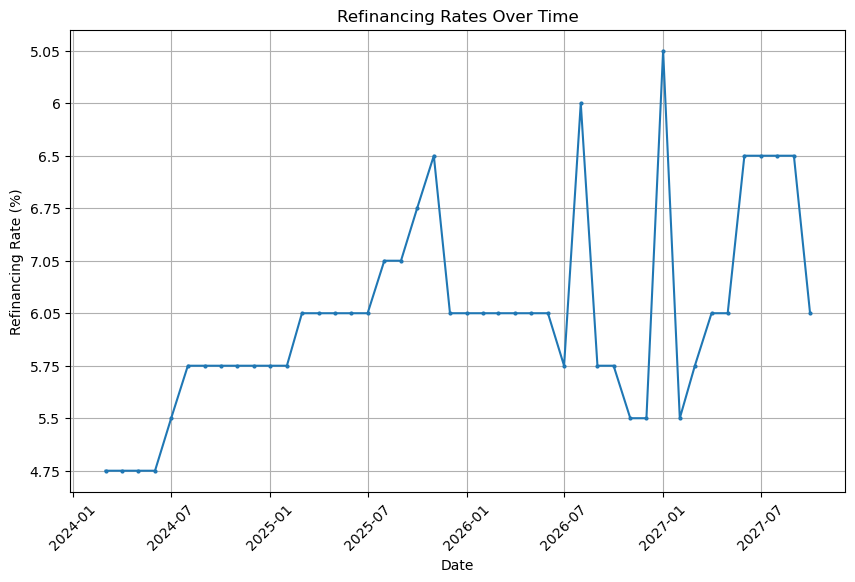

In [121]:
# Now proceed with plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(preds_df['Start_Date'], preds_df['predict'], marker='o', linestyle='-', markersize=2)
#plt.plot(preds_df['Start_Date'], preds_df['Refinancing_Rates'], marker='o', linestyle='-', markersize=2)
plt.title('Refinancing Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.show()

In [122]:
# Extract the year from Start_Date

refinancing_rate = refinancing_rate.reset_index()
years = refinancing_rate['Start_Date'].dt.year

# Filter rows for years 2010 to 2011
df_2010_2011 = refinancing_rate[(refinancing_rate['Start_Date'] >= '2010-01-01') & (refinancing_rate['Start_Date'] <= '2011-03-01')]

print(df_2010_2011)

   Start_Date  Refinancing_Rates
73 2010-01-01               5.50
74 2010-02-01               6.00
75 2010-03-01               6.50
76 2010-04-01               7.00
77 2010-05-01               7.25
78 2010-06-01               7.25
79 2010-07-01               7.25
80 2010-08-01               7.25
81 2010-09-01               7.25
82 2010-10-01               7.25
83 2010-11-01               7.25
84 2010-12-01               7.25
85 2011-01-01               7.25
86 2011-02-01               7.75
87 2011-03-01               8.25


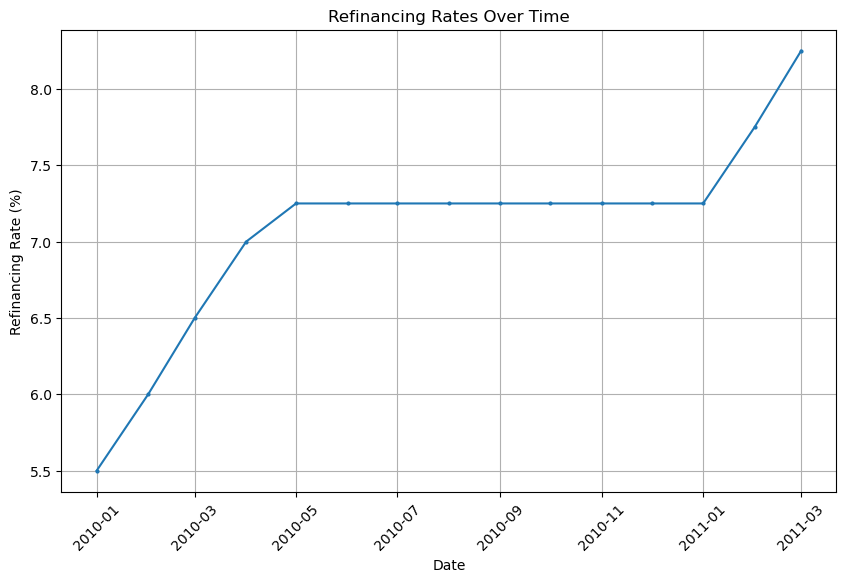

In [123]:
# Now proceed with plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(df_2010_2011['Start_Date'], df_2010_2011['Refinancing_Rates'], marker='o', linestyle='-', markersize=2)
#plt.plot(preds_df['Date'], preds_df['predict'], marker='o', linestyle='-', markersize=2)
#plt.plot(preds_df['Start_Date'], preds_df['Refinancing_Rates'], marker='o', linestyle='-', markersize=2)
plt.title('Refinancing Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.show()

In [124]:
#refinancing_rate = refinancing_rate.reset_index()
refinancing_rate

,Start_Date,Refinancing_Rates
0,2003-12-01,9.00
1,2004-01-01,9.00
2,2004-02-01,9.00
3,2004-03-01,6.00
4,2004-04-01,6.00
...,...,...
240,2023-12-01,9.25
241,2024-01-01,8.75
242,2024-02-01,8.75
243,2024-03-01,8.50


In [125]:
# Ensure both DataFrames have the date in the same format and column name
#preds_df.rename(columns={'Date': 'Start_Date','predict':'Refinancing_Rates'}, inplace=True)

# Concatenate the dataframes one after the other along the rows (axis=0)
combined_df = pd.concat([refinancing_rate, preds_df], axis=0)

# Reset the index of the combined dataframe to avoid any duplicate indices
combined_df.reset_index(drop=True, inplace=True)

import pandas as pd

# Assuming df is your DataFrame

# Use 'combine_first' to fill in NaN values in 'Refinancing_Rates' with those from 'predict'
combined_df['Refinancing_Rates'] = combined_df['Refinancing_Rates'].combine_first(combined_df['predict'])

# Optionally, if you want to drop the 'predict' column afterwards
combined_df = combined_df.drop('predict', axis=1)


In [126]:
combined_df

,Start_Date,Refinancing_Rates
0,2003-12-01,9.0
1,2004-01-01,9.0
2,2004-02-01,9.0
3,2004-03-01,6.0
4,2004-04-01,6.0
...,...,...
284,2027-06-01,6.5
285,2027-07-01,6.5
286,2027-08-01,6.5
287,2027-09-01,6.5


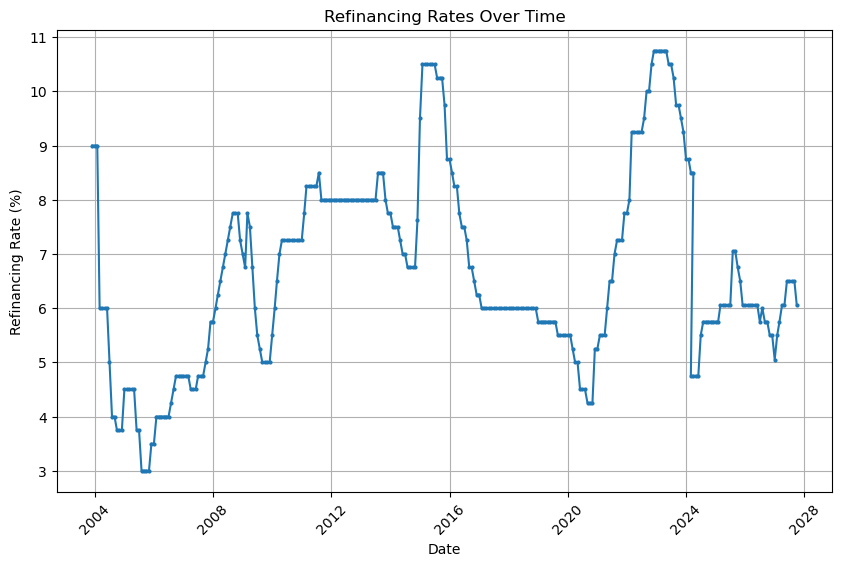

In [127]:
# Now proceed with plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(combined_df['Start_Date'], combined_df['Refinancing_Rates'], marker='o', linestyle='-', markersize=2)
plt.title('Refinancing Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.show()

In [128]:
print(h2o.estimators.xgboost.H2OXGBoostEstimator.available())

Cannot build an XGBoost model - no backend found.
False
